# The Effects of a Changing Environment on the Spectra of Mars Analog Samples

This work constitutes the data analysis section for my MSc thesis at UCL (currently in progress, due August 2024). My project is advised by Dr Louisa Preston, with support from Professor Lewis Dartnell and Connor Ballard.

In this notebook, I will be analysing how lyophilization affects the spectra of Mars analog samples. This analysis includes:

* Mid-IR spectra collected at the Mullard Space Science Laboratory using the Agilent 4300 Handheld FTIR spectrometer, docked onto a table-top setup and equipped with a Diamond-ATR sampling module.
* Vis-NIR spectra collected at the University of Westminster using the RxSpec 700Z spectrometer. There are spectral joins in this data at $1000cm^{-1}$ and $1850cm^{-1}$, so features around these wavenumbers should be disregarded in analysis. 

In [174]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir

## Samples

I am analysing sandstone from Antarctica (denoting Antarctica crytoendolith sandstone as ACE SST) and <a href="https://doi.org/10.1016/j.icarus.2023.115568">SOPHIA</a> (Simulant for Oxia Planum: Hydrated, Igneous, and Amorphous). I also analyse the spectra for a microbial mat collected on the Robert Falcon Scott expedition to Antarctica in 1910. For the SOPHIA sample, I analyse the spectra with and without microbes from the mat mixed in. For each sample, I collected multiple spectra to analyse different parts of the sample. These are labeled as subsamples (SS). I label the samples as: 

* ACE SST BP5 - crustal layer of Antarctica sandstone sample from study BP5
* ACE SST BP6 - crustal layer of Antarctica sandstone sample from study BP6
* ACE SST BLACK - black layer of Antarctica sandstone sample
* SCOTT MAT - microbial mat from the Scott expedition
* SOPHIA - simulant
* SOPHIA MAT - simulant with microbial mat mixed in

In [175]:
def load_spectra(dir, delimiter, skiprows = 0, skipfooter = 0):
    result = {}

    for sample in listdir(dir):
        result[sample] = []
        
        for subsample in listdir(dir + sample):
            data = np.loadtxt(dir + sample + '/' + subsample, delimiter=delimiter, skiprows=skiprows)
            data = np.transpose(data)

            if (skipfooter != 0):
                data = [data[0][0:-skipfooter], data[1][0:-skipfooter]]

            result[sample].append(data)

    return result

In [176]:
BEFORE_VIS_NIR = load_spectra('./Data/BEFORE LYO/VIS NIR/', '\t')

In [177]:
AFTER_VIS_NIR = load_spectra('./Data/AFTER LYO/VIS NIR/', '\t')

In [178]:
BEFORE_MIR = load_spectra('./Data/BEFORE LYO/MID IR/', ',', 29)

In [179]:
AFTER_MIR = load_spectra('./Data/AFTER LYO/MID IR/', ',', 1, 216)

## Plotting Functions

In [180]:
def plot_sample(samples, title):
    for sample, subsamples in samples.items():
        fig, ax = plt.subplots()

        ax.set_title(title + ': ' + sample)
        ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Reflectance')
        ssLabel = 1

        for curr_intensity, intensity in subsamples:
            ax.plot(curr_intensity, intensity, label='SS ' + str(ssLabel))
            ssLabel += 1
        
        ax.invert_xaxis()
        ax.legend()
        
        fig.savefig('./Spectra/' + title + '/' + sample + '.png')

In [181]:
def plot_before_after(before, after, title):
    for sample_before, subsamples_before in before.items():
        subsamples_after = after[sample_before]
        fig, ax = plt.subplots()
        ax.set_title(title + ': ' + sample_before)
        ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Reflectance')
        ssLabel = 1

        for curr_intensity, intensity in subsamples_before:
            ax.plot(curr_intensity, intensity, '--', label='SS ' + str(ssLabel) + ' (before)')
            ssLabel += 1

        ssLabel = 1
        for curr_intensity, intensity in subsamples_after:
            ax.plot(curr_intensity, intensity, '-', label='SS ' + str(ssLabel) + ' (after)')
            ssLabel += 1
        
        ax.invert_xaxis()
        ax.legend()

        fig.savefig('./Spectra/' + title + '/' + sample_before + '.png')

## VIS-NIR Analysis

### Before Lyophilization

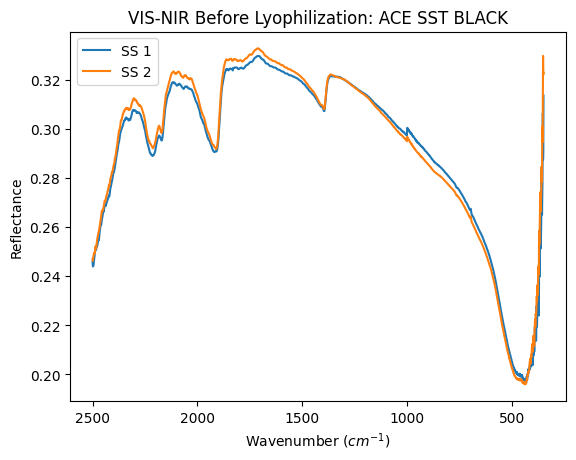

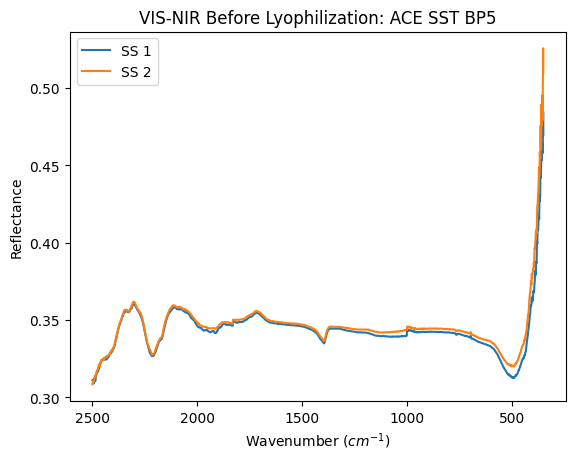

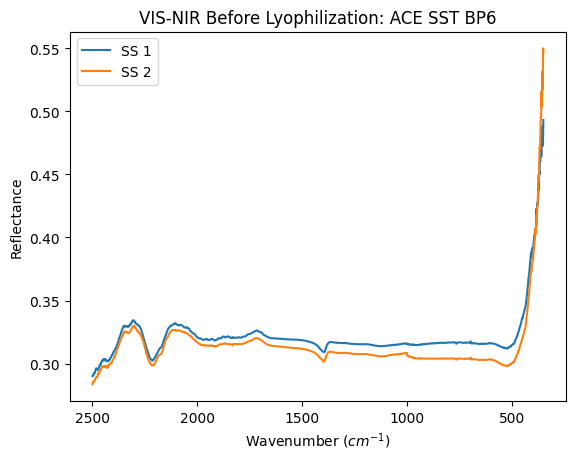

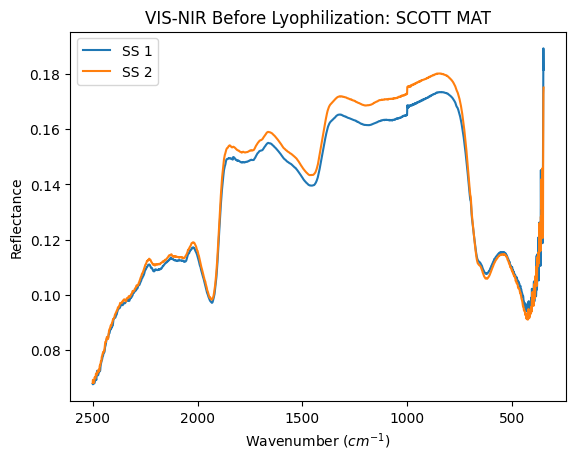

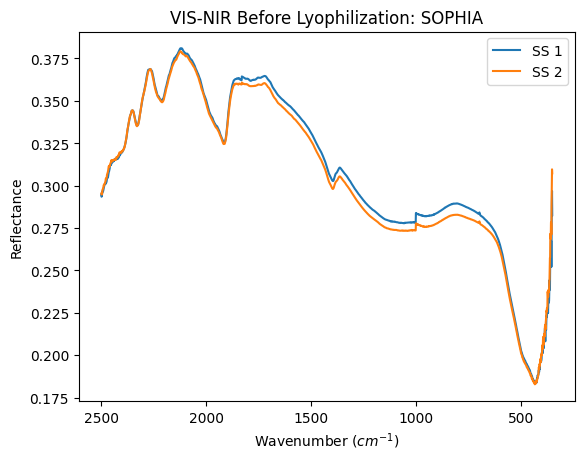

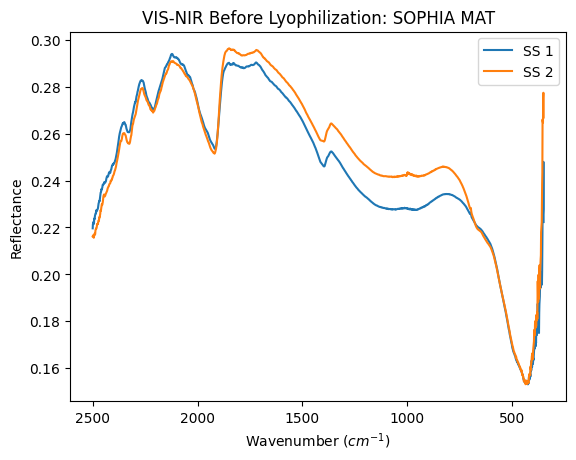

In [182]:
plot_sample(BEFORE_VIS_NIR, 'VIS-NIR Before Lyophilization')

### After Lyophilization

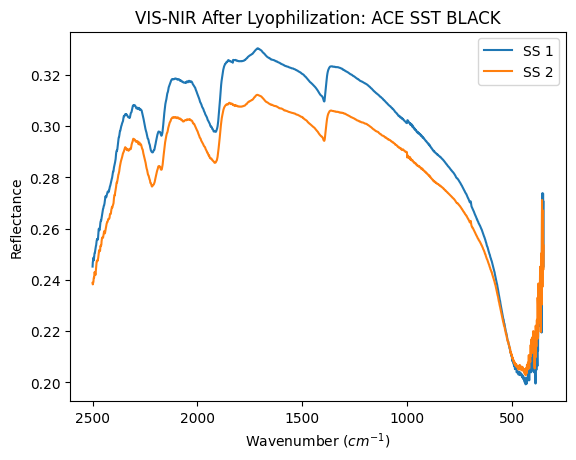

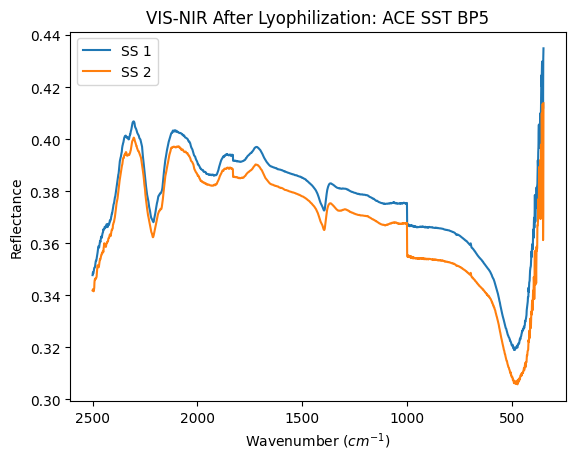

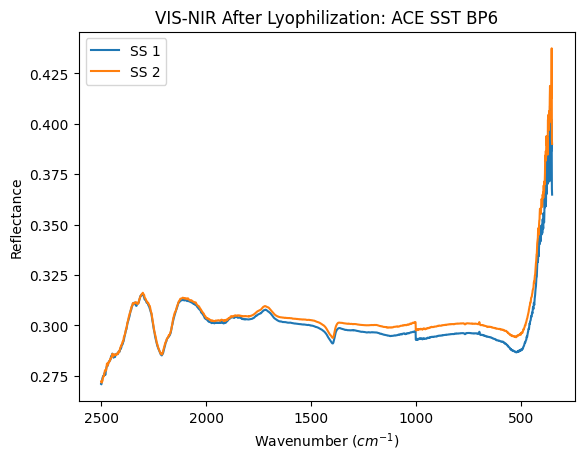

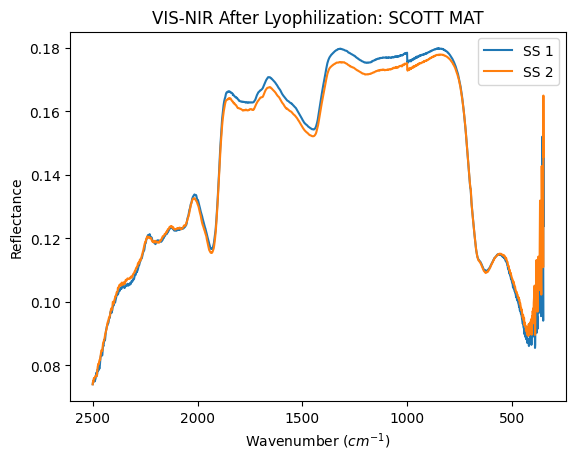

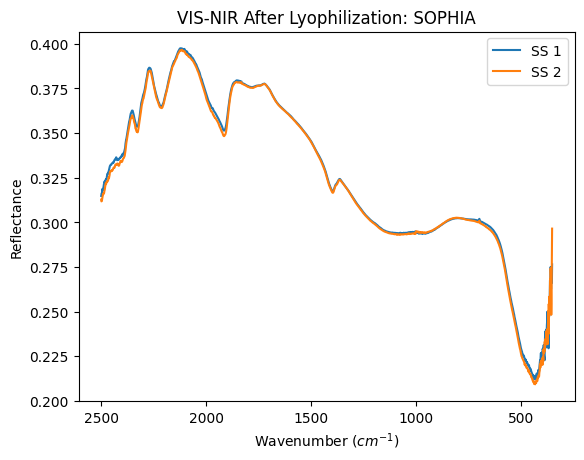

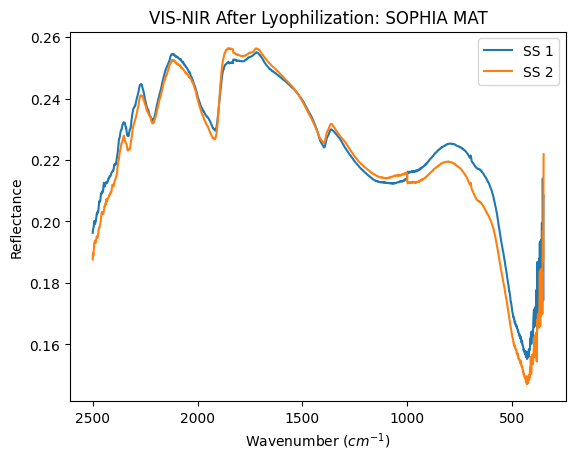

In [183]:
plot_sample(AFTER_VIS_NIR, 'VIS-NIR After Lyophilization')

### Comparison

#### Direct

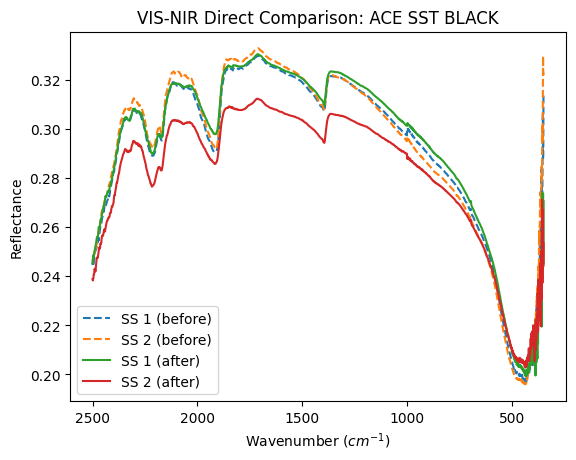

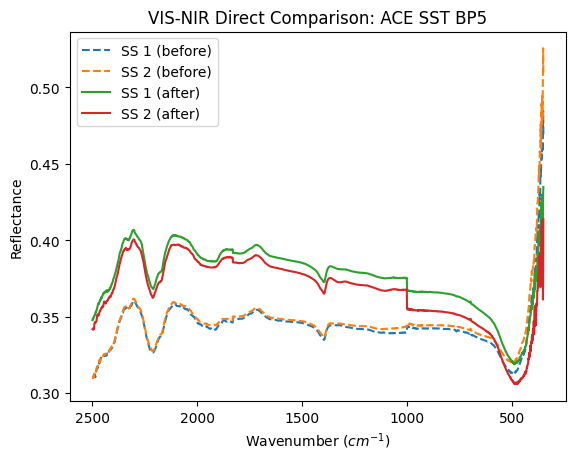

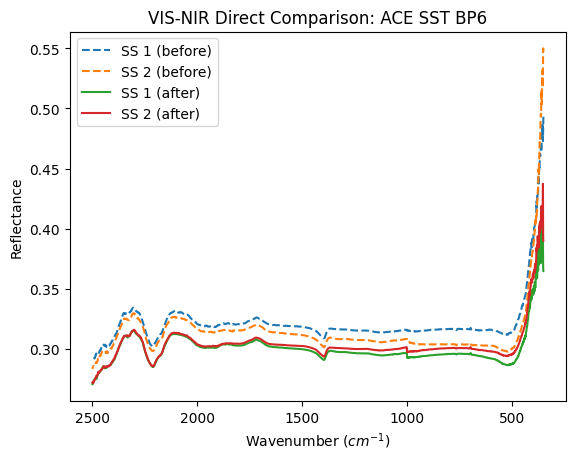

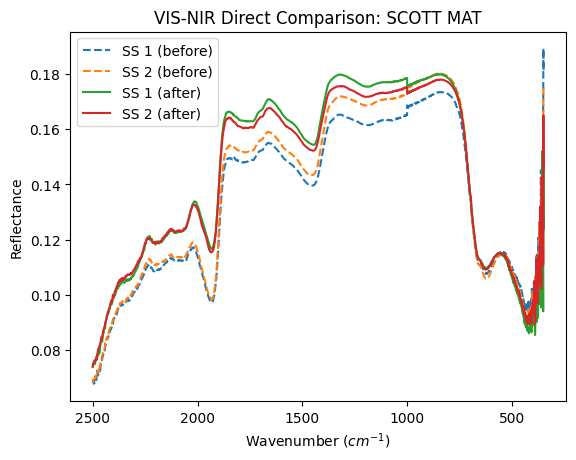

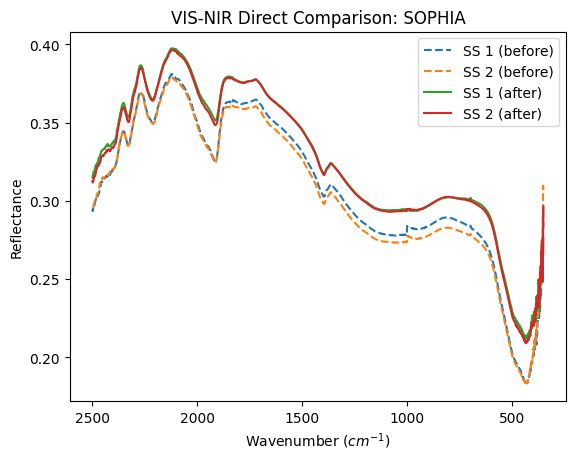

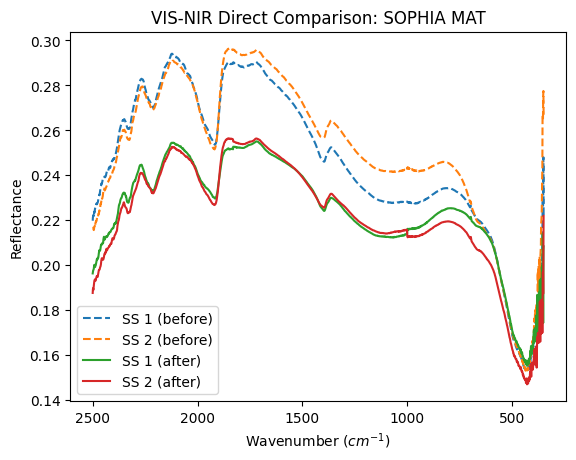

In [184]:
plot_before_after(BEFORE_VIS_NIR, AFTER_VIS_NIR, 'VIS-NIR Direct Comparison')

#### Absolute Intensity Differences

Comparing the averages for each sample allows us to visualise the differences more easily within each sample. To compare the effects of lyophilization across the samples, I want to compare the intensities between each subsample at every wavenumber and plot the differences from all samples on a single graph.

A crude metric for quantifying the intensity difference at each wavenumber, $\delta_\nu$, is summing the intensity differences between each subsample before and after lyophilization.

* $A_i$: intensity for subsample $i$ after lyophilization
* $B_j$: intensity for subsample $j$ before lyophilization
* $n$: number of subsamples after lyophilization
* $m$: number of subsamples before lyophilization

$\delta_\nu = \Sigma_{i}^n\Sigma_{j, i \neq j}^m A_i - B_j$

* $\delta_\nu = 0$: same intensity before and after lyophilization
* $\delta_\nu < 0$: peak is weaker after lyophilization
* $\delta_\nu > 0$: peak is stronger after lyophilization

This metric is not ideal because for many of the subsamples there were relatively large intensity differences, which the metric will be very sensitive to. Removing the averages first will help mitigate this, but ideally each subsample would show more similar spectra than for the data collected. The more subsamples obtained, the more reliable this metric will be.

If there are features shown across different samples, this is inidicative that the feature has not arisen due to fluctuations within a sample.

In [187]:
def plot_intensity_diff(before, after, title):
  fig, ax = plt.subplots()
  ax.set_title(title)
  ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Intensity Increase After Lyophilization ($\\delta$)')

  for sample_before, subsamples_before in before.items():
    subsamples_after = after[sample_before]

    const_wavenumbers = subsamples_before[0][0]
    n_wavenumbers = len(const_wavenumbers)
    
    wavenumber_diffs = list(np.full(n_wavenumbers, 0))

    for i in range(len(subsamples_before)):
      for j in range(len(subsamples_after)):
        for k in range(n_wavenumbers):
          wavenumber_diffs[k] += (subsamples_after[j][1][k] - subsamples_before[i][1][k])

    ax.plot(const_wavenumbers, wavenumber_diffs, '-', label=sample_before)
    
  ax.invert_xaxis()
  ax.legend()

  fig.savefig('./Spectra/' + title + '.png')

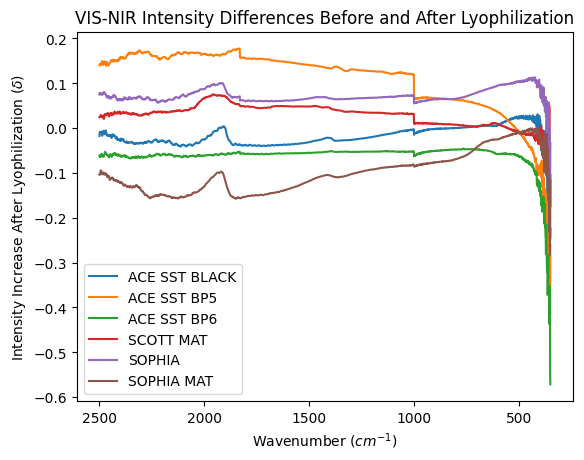

In [188]:
plot_intensity_diff(BEFORE_VIS_NIR, AFTER_VIS_NIR, 'VIS-NIR Intensity Differences Before and After Lyophilization')

My next steps will be to analyse this graph in more detail, checking out features in the graph above to see the bonds that they correspond to and checkign this against the expected bonds in the samples. Some notable features that I will explore more:

* $2200cm^{-1}$ - ACE SST BP5, ACE SST BP6 increase
* $1900cm^{-1}$ - ACE SST BLACK, SOPHIA, SOPHIA MAT increase, SCOTT MAT decrease
* $1750cm^{-1}$ - SCOTT MAT increase
* $1400cm^{-1}$ - ACE SST BLACK, SOPHIA, SOPHIA MAT increase, SCOTT MAT decrease
* $700cm^{-1}$ - ACE SST BLACK, ACE SST BP5, ACE SST BP6, SCOTT MAT decrease

I would expect the base of each to lie on $\delta = 0$, so this highlights a deficiency in the current data, data processing, and/or metric.

The peaks around $1450cm^{-1}$ and $1950cm^{-1}$ <a href="https://doi.org/10.1016/S0016-7061(98)00023-8">may be attributed to OH bonds</a>, so changes here are consistent with the lyophilization process, but it is not immediately clear why there are increases in some sampels and decreaeses in others. I would expect a decrease around these peaks, so my initial thoughts are that there is some issue with the metric. A manual analysis of the depths of each peak could confirm this.

My next steps will be to continue analysing this data, investigating more of the peaks and finding ways to clean up the spectra to determine changes before and after lyophilization more easily. In particular, I will be looking at the lower wavenumbers, as there may be more changes in this area that are harder to visualise and there may be room for cleaning up the spectra as the intensities becomes less accurate at wavenumber boundaries.

## MID IR Analysis

### Before Lyophilization 

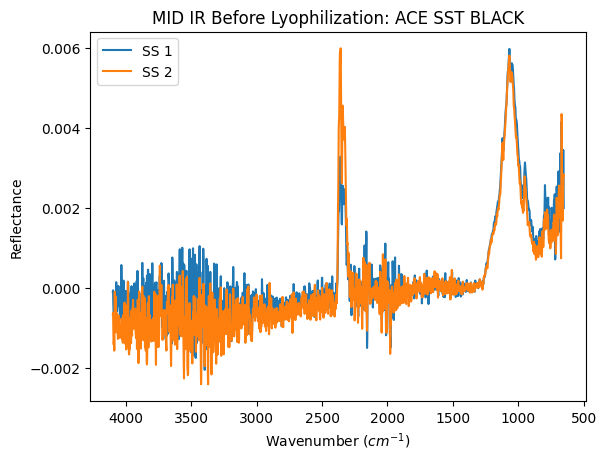

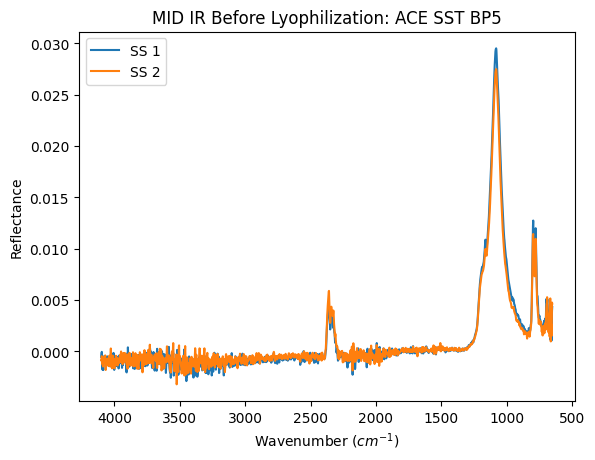

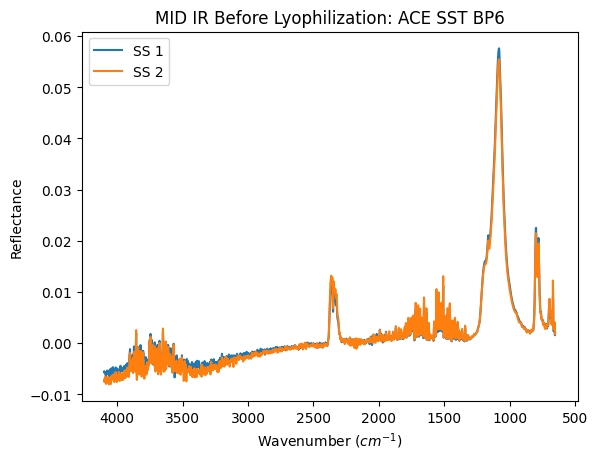

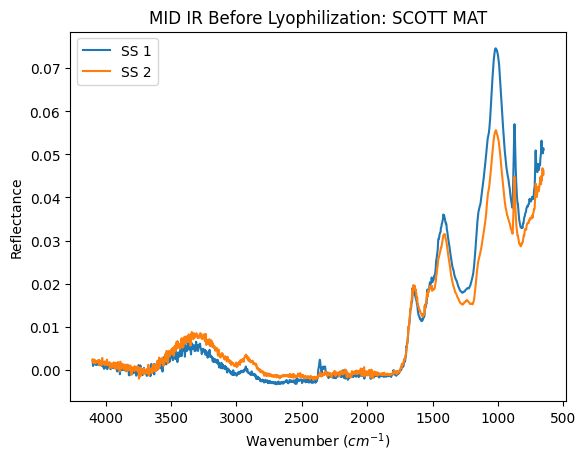

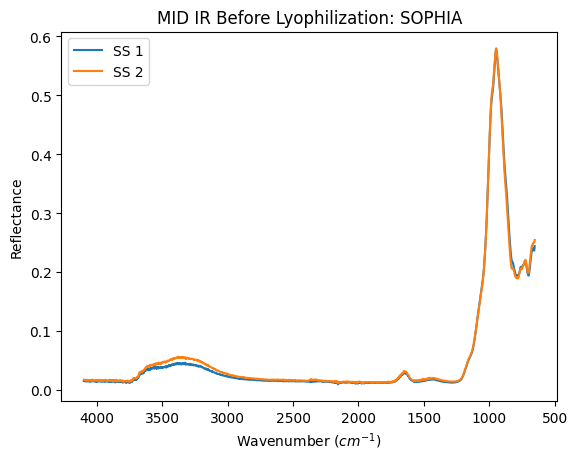

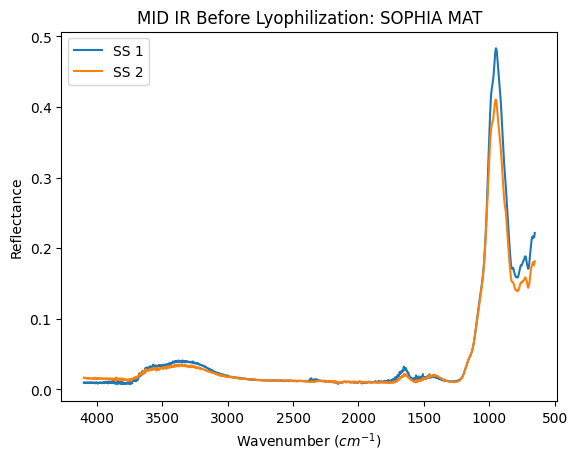

In [190]:
plot_sample(BEFORE_MIR, 'MID IR Before Lyophilization')

### After Lyophilization

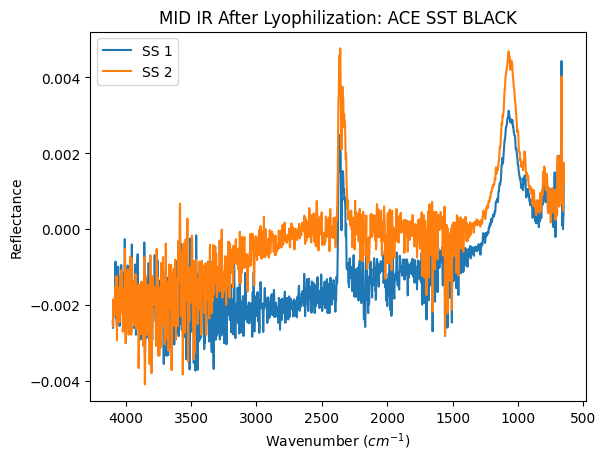

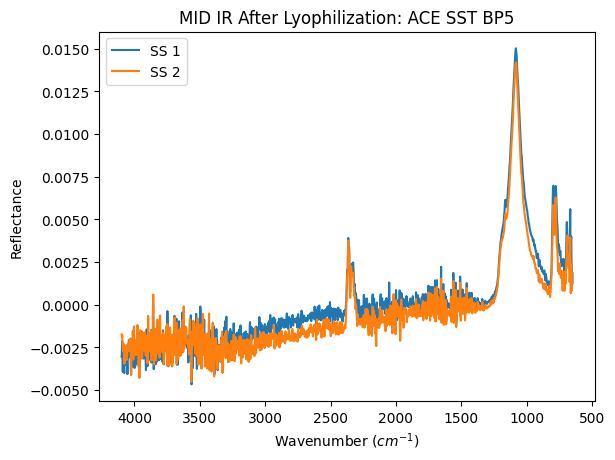

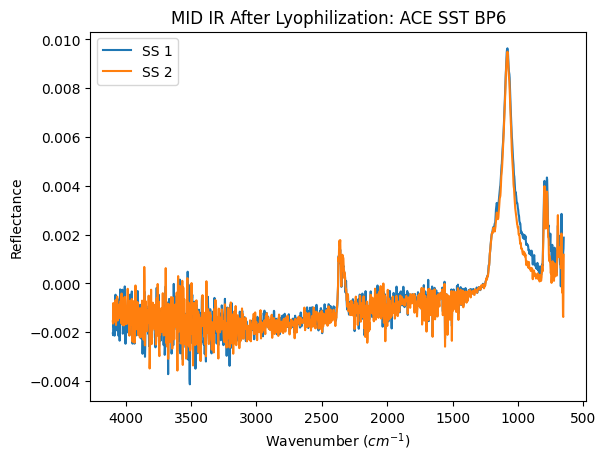

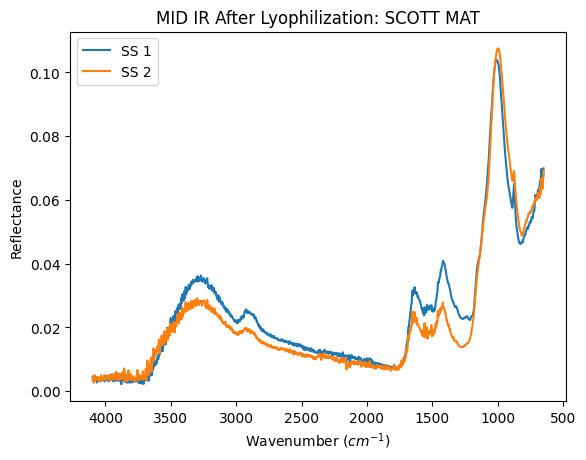

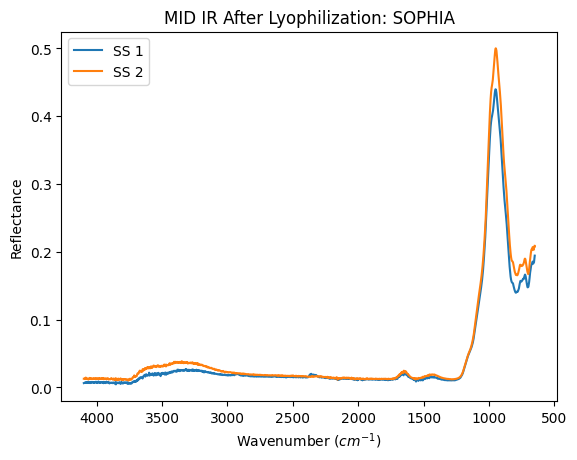

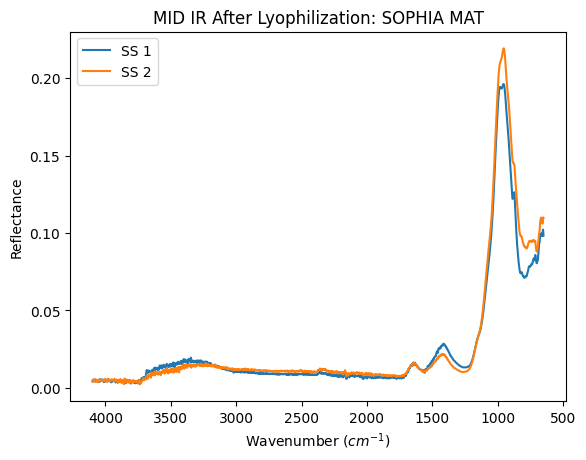

In [191]:
plot_sample(AFTER_MIR, 'MID IR After Lyophilization')

### Comparison

#### Direct

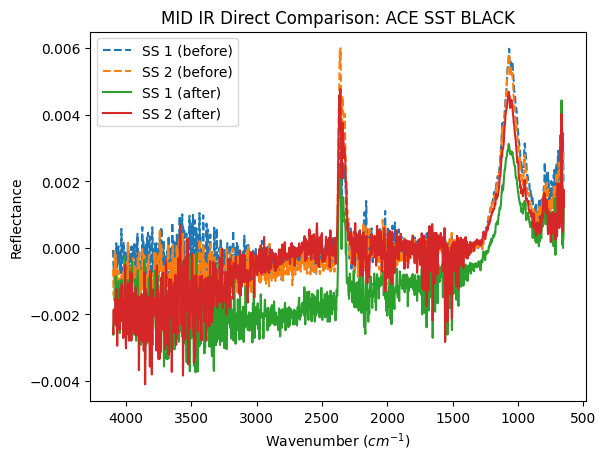

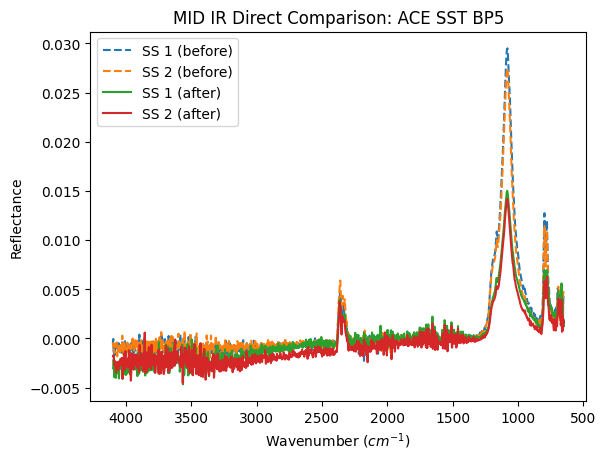

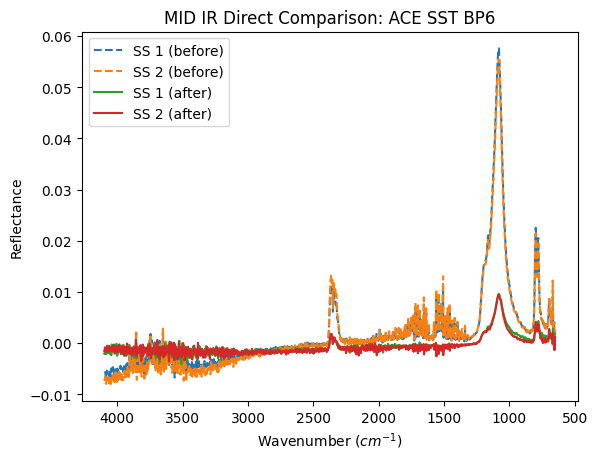

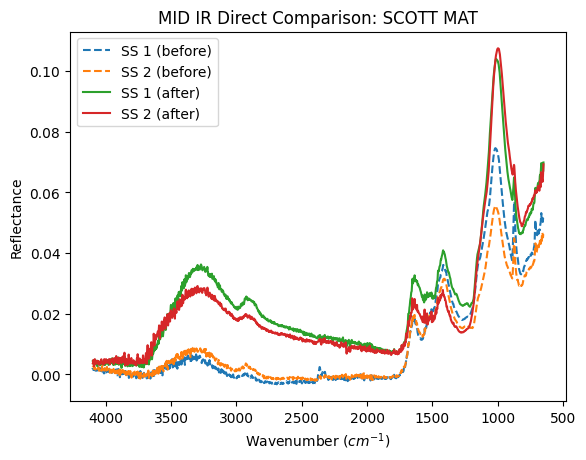

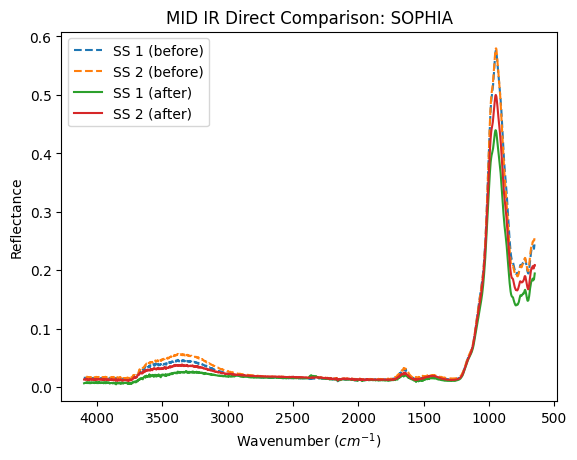

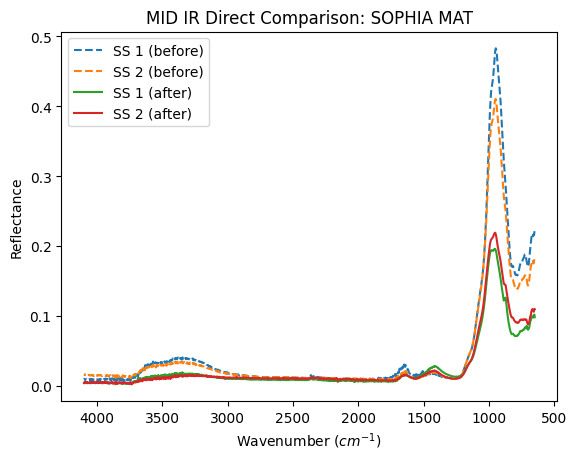

In [192]:
plot_before_after(BEFORE_MIR, AFTER_MIR, 'MID IR Direct Comparison')

#### Absolute Intensity Differences

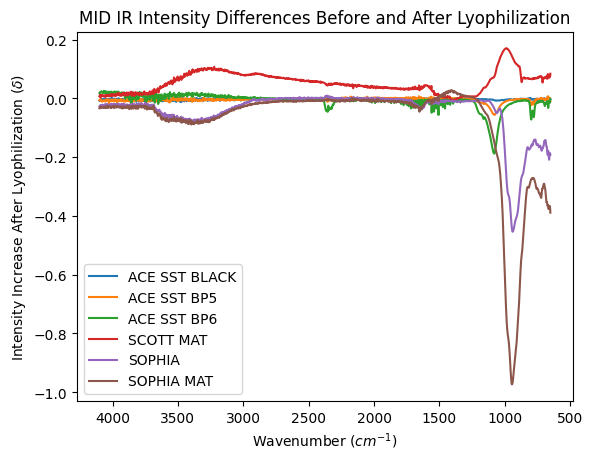

In [194]:
plot_intensity_diff(BEFORE_MIR, AFTER_MIR, 'MID IR Intensity Differences Before and After Lyophilization')